# Example: Fit an experimental (or theoretical) dispersion curve to the propagation constants Taylor Series expansion to implement in fiberdesk

you might want to install

conda install -c conda-forge lmfit

In [72]:
import numpy as np
import pandas as pd
import math as m
import matplotlib
import matplotlib.pyplot as plt

from lmfit import Model, Parameters

read the dispersion values, here given in nm and ps/km/nm, to a pandas dataframe df

In [105]:
name = 'dispersion.csv'

_encoding = "utf-8"
with open(name) as _file:
    _encoding = _file.encoding
    print(_encoding)

df = pd.read_csv(name, encoding = _encoding, delimiter=";", decimal=",")
print (df)

UTF-8
    lambda in nm  D in ps/nm/km
0        666.967      -228.2150
1        675.608      -217.8070
2        684.248      -207.4000
3        691.809      -198.4800
4        699.370      -190.0550
..           ...            ...
64      1616.380        66.3648
65      1636.900        67.3478
66      1657.430        68.6000
67      1673.630        69.3157
68      1696.310        70.2978

[69 rows x 2 columns]


Plot the experimental data.

Text(0, 0.5, 'D / ps/km/nm')

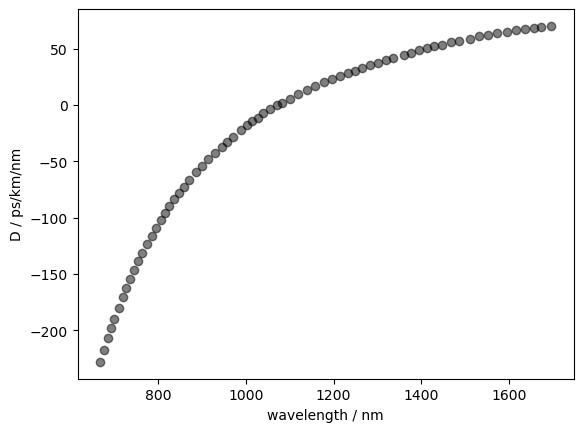

In [106]:
disp = df.to_numpy()

wavelength_values = disp[:,0]*1e-9
dispersion_values = disp[:,1]

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.plot(wavelength_values*1e9,dispersion_values,'o',color='black',alpha=0.5)
ax0.set_xlabel('wavelength / nm')
ax0.set_ylabel('D / ps/km/nm')

Set the fitting variables and some parameter, e.g. which wavelength (~omega0) should be the Taylor series expanded

Text(0, 0.5, 'beta2 / ps²/m')

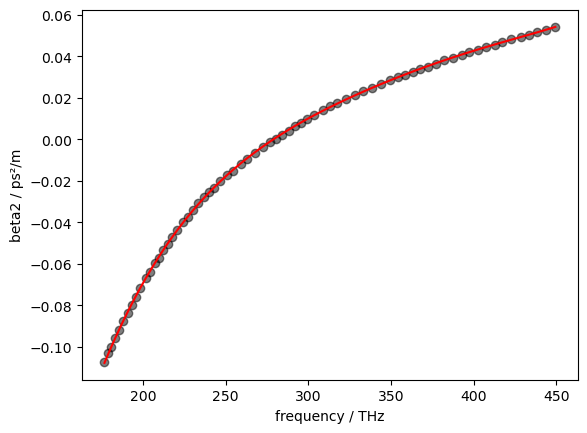

In [107]:
c = 299792458.0 #m/s

fit_wavelength = 1030.0*1e-9
omega0 = c/fit_wavelength*2*m.pi

omega_axis = c / wavelength_values * 2.0 * m.pi
beta2_values = - dispersion_values / 2.0 / m.pi / c * (wavelength_values*1e9)**2

# Define the Taylor fit function
def Taylor(x, **params):
    # x is omega-omega0
    y = np.zeros(x.shape[0],dtype=float)

    parnames = sorted(params.keys())
    for n, pname in enumerate(parnames):    
        y += 1.0/float(m.factorial(n))*params[pname]*np.power(x,n)
        
    return y

_TaylorFit = Model(Taylor)

# Parameter names and starting values
params = Parameters()
params.add('b2', value=1e-3)
params.add('b3', value=1e-5)
params.add('b4', value=1e-7)
params.add('b5', value=1e-9)
params.add('b6', value=1e-11)
params.add('b7', value=1e-9)
params.add('b8', value=1e-11)

X = (omega_axis-omega0)*1e-12 # rescale to fit betas to ps²

out = _TaylorFit.fit(beta2_values, params, x=X)

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.plot(omega_axis/1e12/2.0/m.pi,beta2_values,'o',color='black',alpha=0.5)
ax0.plot(omega_axis/1e12/2.0/m.pi,out.best_fit,color='red',alpha=1)
ax0.set_xlabel('frequency / THz')
ax0.set_ylabel('beta2 / ps²/m')

In [108]:
print('final values for fiberdesk')
parnames = sorted(out.params.keys())
for n, pname in enumerate(parnames):    
    print(pname,' = ',out.params[pname].value, 'ps^{}/m'.format(n+2))

final values for fiberdesk
b2  =  0.00599789403123003 ps^2/m
b3  =  7.461642155706941e-05 ps^3/m
b4  =  -1.0470123949202561e-07 ps^4/m
b5  =  3.384079356694215e-10 ps^5/m
b6  =  -1.0739129508509775e-12 ps^6/m
b7  =  8.309735974155976e-16 ps^7/m
b8  =  5.384954842935194e-18 ps^8/m
